# Udacity P5: Vehicle detection and tracking 

In [9]:
from libraries import *
%matplotlib inline

## Basic functions (mostly obtained form Udacity class)

### Basic parameter definition

In [10]:
orient = 32
pix_per_cell = 16
cell_per_block = 2
hist_bins = 32
spatial_size = (16,16)

### Function to convert between color schemes

In [11]:
def convert_color(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)
    return feature_image

### Function to extract features by HOG technique and predict the resulting

In [12]:
count = 0
def find_cars(img, color_space, ystart, ystop, scale, model, X_scaler, show_all=False):
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1
    nfeat_per_block = orient*cell_per_block**2

    window = 64
    nblocks_per_window = (window // pix_per_cell)-1
    cells_per_step = 1  
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = hog(ch1, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, visualise= False, feature_vector=False)
    hog2 = hog(ch2, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, visualise= False, feature_vector=False)
    hog3 = hog(ch3, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, visualise= False, feature_vector=False)

    box_list = []
    global count
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            spatial_features = cv2.resize(subimg, spatial_size).ravel()

            test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))
            test_prediction = model.predict(test_features)

            if test_prediction == 1 or show_all:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                box_list.append(box)

    return box_list

### Extract feature function used to extract features from an image using HOG 

### function that creates the slide window

In [14]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.33, 0.2)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    x_start_stop = [np.int(i) for i in x_start_stop]
    y_start_stop = [np.int(i) for i in y_start_stop]
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)

    window_list = []

    for ys in range(ny_windows):
        for xs in range(nx_windows):

            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            window_list.append(((startx, starty), (endx, endy)))

    return window_list

### Function for creating the boundary boxes around cars

In [15]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6, make_copy=True):
    if make_copy:
        imcopy = np.copy(img)
    else:
        imcopy = img
    for bbox in bboxes:

        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)

    return imcopy

### Class image_tracer

In [17]:
class image_tracer(object):
    def __init__(self, file_car, file_non_car):
        self.route_car = self.get_files(file_car)
        self.route_non_car = self.get_files(file_non_car)
        self.car_images = [mpimg.imread(i) for i in self.route_car]
        self.non_car_images = [mpimg.imread(i) for i in self.route_non_car]
        
    def get_files(self, route, lst_ext=['.jpeg', '.png', '.jpg']):
        assert(os.path.exists(route))
        result = []
        for directory, dirs, files in os.walk(route):
            result = result + [os.path.join(directory, f) for f in files if os.path.splitext(f)[1] in lst_ext]
        return result

    def get_all_image(self):
        """Get a list of images and their labels"""
        X = np.vstack((self.car_images, self.non_car_images))
        y = np.hstack((np.ones(len(self.car_images)),
                       np.zeros(len(self.non_car_images))))
        return X, y
    
    def boxe_creator(image, num):
        for num1 in num:
            cv2.rectangle(new_image, num1[0], num1[1], (10, 10, 150), 4)
        return new_image

color_space = 'YCrCb'


### Class Model which divides set into train and validation set before performing training

In [18]:
class Model(object):
    def __init__(self, model_file=None):
        if model_file is None:
            self.model = LinearSVC()
            self.scalar = None
        else:
            with open(model_file, 'rb') as f:
                self.model, self.scalar = pickle.load(f)

    def save_model(self):
        with open('model.pkl', 'wb') as f:
            pickle.dump((self.model,self.scalar), f)

    def preprocess(self, images):
        features = []
        for i in images:
            features.append(extract_features(i, color_space=color_space, hog_channel='ALL'))
        return np.array(features).astype(np.float64)

    def train(self, X, y, test_size=0.3):
        """Given a list of images and their label, train the model."""
        features = self.preprocess(X)

        self.scalar = StandardScaler().fit(features)
        scaled_X = self.scalar.transform(features)

        stat = np.random.randint(0, 100)
        scaled_X, y = shuffle(scaled_X, y)
        X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                            test_size=test_size,
                                                            random_state=stat)
        self.model.fit(X_train, y_train)

        score = self.model.score(X_test, y_test)

    def predict(self, feature):
        return self.model.predict(feature)

### Class to search for cars in the window

In [19]:
class CarSearch(object):
    def __init__(self, model):
        self.model = model
        self.history = collections.deque(maxlen=7)

    def __search_cars_in_image(self, img):
        image_size = img.shape
        box_list = []
        def search(ybeg, yend, scale):
            return find_cars(img, color_space, ybeg, yend, scale,
                             self.model, self.model.scalar,
                             show_all=False)

        box_list += search(360, 490, 1)
        box_list += search(390, 570, 2)
        return box_list

    def annotate_cars_in_image(self, img):
        box_list = self.__search_cars_in_image(img)
        cars = draw_boxes(img, box_list)
        return cars

    def __add_heat(self, box_list):
        heat = np.zeros((720, 1280)) #hardcode for now
        for box in box_list:
            heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        self.history.append(heat)

    def generate_heat(self):
        heat = np.sum(np.array(self.history), axis=0)
        if len(self.history) == self.history.maxlen:
            heat[heat <= 3] = 0
        return heat

    def annotate_cars_in_video(self, test_image):
        box_list = self.__search_cars_in_image(test_image)
        self.__add_heat(box_list)

        heat = self.generate_heat()

        pixels, ncars = label(heat)

        new_boxes = []
        for i in range(1, ncars+1):
            nonzero = (pixels == i).nonzero()

            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            box = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            new_boxes.append(box)

        draw_boxes(test_image, new_boxes, make_copy=False)
        return test_image

In [20]:
def start_train(route_car, route_non_car):
    start_train_data = image_tracer(route_car, route_non_car)
    #training_data = CarImages(vehicle_folder, nonvehicle_folder)
    model = Model()
    search = CarSearch(model)

    X, y = start_train_data.get_all_image()
    model.train(X, y)
    model.save_model()
    return model

if __name__ == '__main__':
    start_train('vehicles', 'non-vehicles')

In [21]:
def show_image(img, ax=None):
    if ax is None:
        ax = plt
    if len(img.shape) == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
def show_images(img_titles):
    cols = len(img_titles)
    f, axs = plt.subplots(1, cols, figsize=(24, 9))
    f.tight_layout()
    for i, image_title in enumerate(img_titles):
        if type(image_title) is tuple or type(image_title) is list:
            img, title = image_title
        else:
            img = image_title
            title = "unspecified"
        axs[i].set_title(title, fontsize=30)
        show_image(img, axs[i])
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## HOG detailed

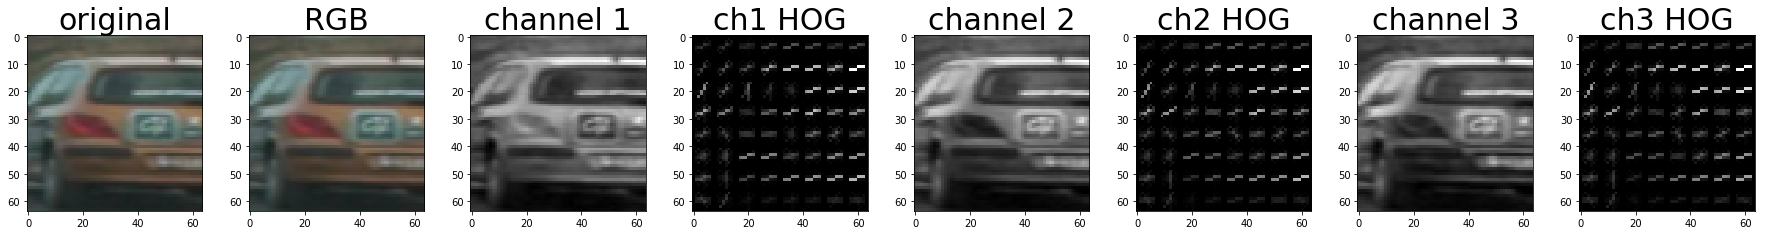

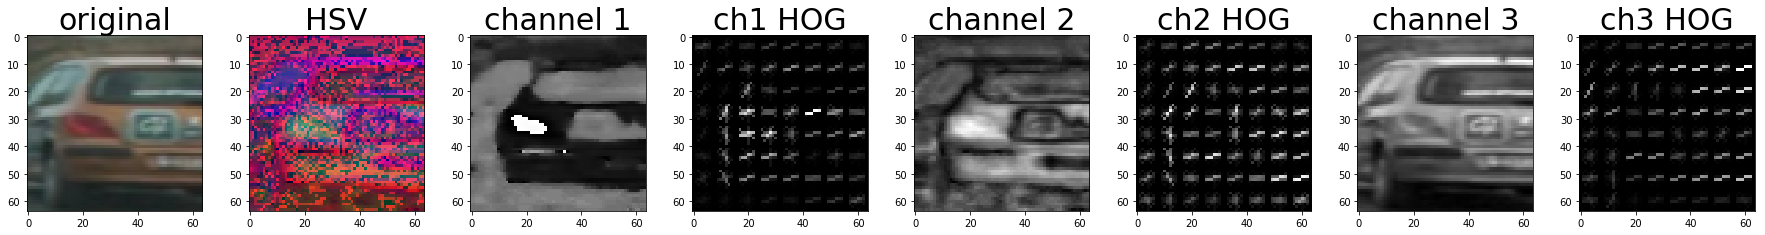

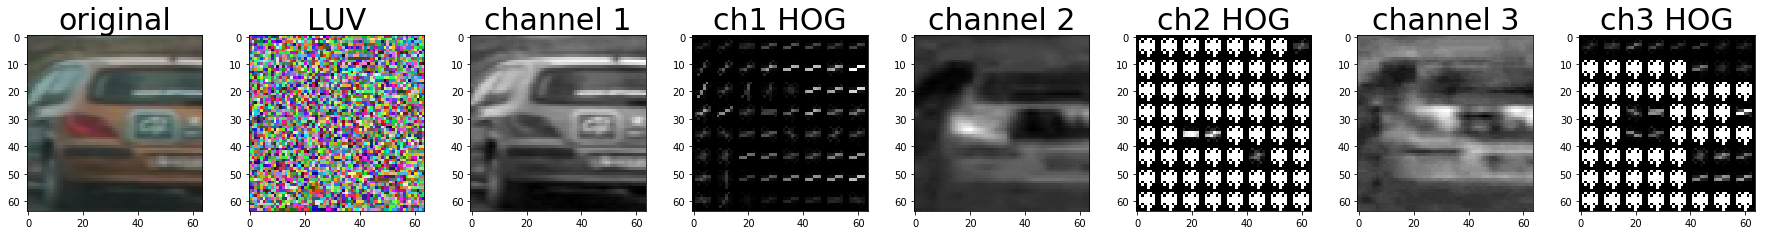

In [22]:
orient=9 
pix_per_cell=8 
cell_per_block=2
spaces = ['RGB', 'HSV', 'LUV']
for s in spaces:
    #test_image = read_image('vehicles/GTI_Right/image0775.png')
    test_image = mpimg.imread('vehicles/GTI_Right/image0775.png')
    
    conv = convert_color(test_image, s)
    _, img1 = hog(conv[:,:,0], orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell), 
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise= True, feature_vector=True)
    _, img2 = hog(conv[:,:,1], orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell), 
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise= True, feature_vector=True)
    _, img3 = hog(conv[:,:,2], orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell), 
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise= True, feature_vector=True)
    show_images([(test_image, 'original'),
                 (conv,       s),
                 (conv[:,:,0], 'channel 1'),
                 (img1,       'ch1 HOG'),
                 (conv[:,:,1], 'channel 2'),
                 (img2,       'ch2 HOG'),
                 (conv[:,:,2], 'channel 3'),
                 (img3,       'ch3 HOG')])


# Training

C:\Users\NIKHIL XAVIER\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator LinearSVC from version 0.18.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\NIKHIL XAVIER\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.18.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\NIKHIL XAVIER\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


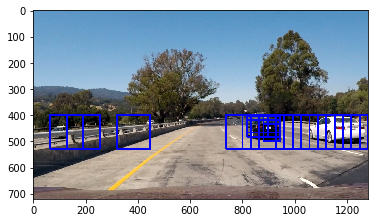

In [6]:
model = Model('model.pkl')
test_image = read_image('test_images/test1.jpg')

search = CarSearch(model)
annotated = search.annotate_cars_in_image(test_image)
show_image(annotated)


# Video

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

count = [0]
def save_image(img):
    mpimg.imsave('output-images/image-%d.png'%count[0], img)
    count[0] += 1
    return img

def process_video(video_filename):
    model = Model('model.pkl')
    search = CarSearch(model) 
    output = "P5_" + video_filename
    input_clip = VideoFileClip(video_filename)
    clip = input_clip.fl_image(search.annotate_cars_in_video)
    %time clip.write_videofile(output, audio=False)
video_1 = 'test_video.mp4'
video_2 = 'video.mp4'
process_video(video_2)

[MoviePy] >>>> Building video P5_project_video.mp4
[MoviePy] Writing video P5_project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [15:15<00:00,  1.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P5_project_video.mp4 

Wall time: 15min 17s


In [8]:
HTML("""
<video width="960" height="720" controls>
  <source src="{0}">
</video>
""".format("annotated_P5_project_video.mp4"))

In [ ]:
### Reference: https://github.com/lijunsong